In [1]:
import pandas as pd

file_path = r"D:\Smart WCET\Smart_WCET_Insight_Engine\OnlyNonTrivial_dt.csv"

df = pd.read_csv(file_path)

print("Shape:", df.shape)
df.head()

Shape: (509426, 53)


,refactoring,file,class,type,cbo,cboModified,fanin,fanout,wmc,dit,...,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty
0,1,\DATASET\abfiles\r0\c17\after\ActiveFiltersPan...,mtgdeckbuilder.frontend.ActiveFiltersPanelTest,class,4,4,0,4,4,1,...,9,0,9,0,0,0,0,55,1,0
1,1,\DATASET\abfiles\r0\c17\after\TagViewerTest.java,mtgdeckbuilder.frontend.TagViewerTest,class,6,7,1,6,7,1,...,21,0,17,1,0,0,0,50,1,0
2,1,\DATASET\abfiles\r0\c17\after\TagTopicTest.java,mtgdeckbuilder.frontend.topics.TagTopicTest,class,4,4,0,4,5,1,...,3,0,3,0,0,0,0,22,1,0
3,1,\DATASET\abfiles\r0\c17\after\TagAddPanel.java,mtgdeckbuilder.frontend.TagAddPanel$Anonymous1,anonymous,1,1,0,1,2,1,...,0,0,0,1,0,0,0,5,-1,0
4,1,\DATASET\abfiles\r0\c17\after\TagTopic.java,mtgdeckbuilder.frontend.topics.TagTopic,class,1,13,12,1,9,1,...,1,0,1,1,0,1,0,14,1,0


In [2]:
df.info()

print("\n Missing values (Top 10):")
print(df.isnull().sum().sort_values(ascending=False).head(10))

print("\n Duplicate rows:", df.duplicated().sum())

print("\n Summary:")
print(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509426 entries, 0 to 509425
Data columns (total 53 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   refactoring             509426 non-null  int64  
 1   file                    509426 non-null  object 
 2   class                   509426 non-null  object 
 3   type                    509426 non-null  object 
 4   cbo                     509426 non-null  int64  
 5   cboModified             509426 non-null  int64  
 6   fanin                   509426 non-null  int64  
 7   fanout                  509426 non-null  int64  
 8   wmc                     509426 non-null  int64  
 9   dit                     509426 non-null  int64  
 10  noc                     509426 non-null  int64  
 11  rfc                     509426 non-null  int64  
 12  lcom                    509426 non-null  int64  
 13  lcom*                   499842 non-null  float64
 14  tcc                 

In [3]:
cols_with_nan = ['lcom*', 'tcc', 'lcc']

for col in cols_with_nan:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

print(df[cols_with_nan].isnull().sum())

lcom*    0
tcc      0
lcc      0
dtype: int64


In [4]:
df_model = df.drop(['file', 'class', 'type'], axis=1)

In [5]:
X = df_model.drop('loopQty', axis=1)
y = df_model['loopQty']

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (407540, 49)
Testing shape: (101886, 49)


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize model
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# Train the model
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.1822
R² Score: 0.9433


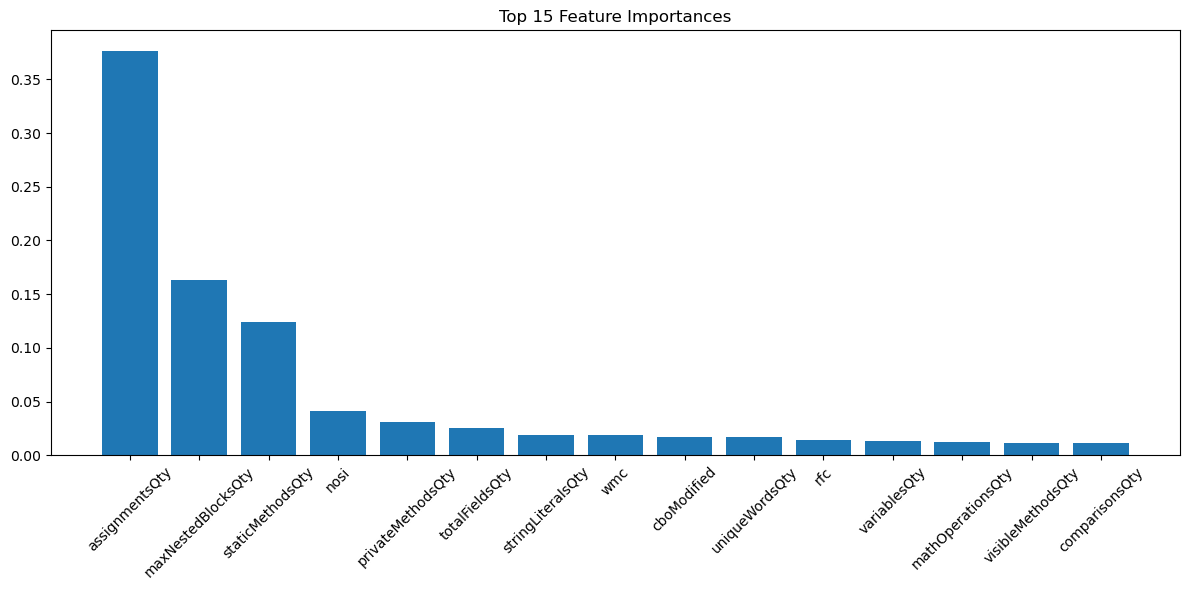

In [8]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 6))
plt.title("Top 15 Feature Importances")
plt.bar(range(15), importances[indices[:15]], align='center')
plt.xticks(range(15), [features[i] for i in indices[:15]], rotation=45)
plt.tight_layout()
plt.show()

In [9]:
#Comparison

In [10]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Skip Random Forest — already done
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        "Model": name,
        "MSE": round(mse, 4),
        "R² Score": round(r2, 4)
    })

# Adding Random Forest manually for comparison
results.append({
    "Model": "RandomForest (prev)",
    "MSE": 0.1822,
    "R² Score": 0.9433
})

# Display sorted table
df_results = pd.DataFrame(results).sort_values(by="R² Score", ascending=False)
print(df_results)

                 Model     MSE  R² Score
2         DecisionTree  0.0359    0.9888
3              XGBoost  0.0538    0.9832
4  RandomForest (prev)  0.1822    0.9433
0     LinearRegression  1.2200    0.6200
1                Ridge  1.2200    0.6200


In [11]:
from sklearn.tree import DecisionTreeRegressor

# Train Decision Tree explicitly
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

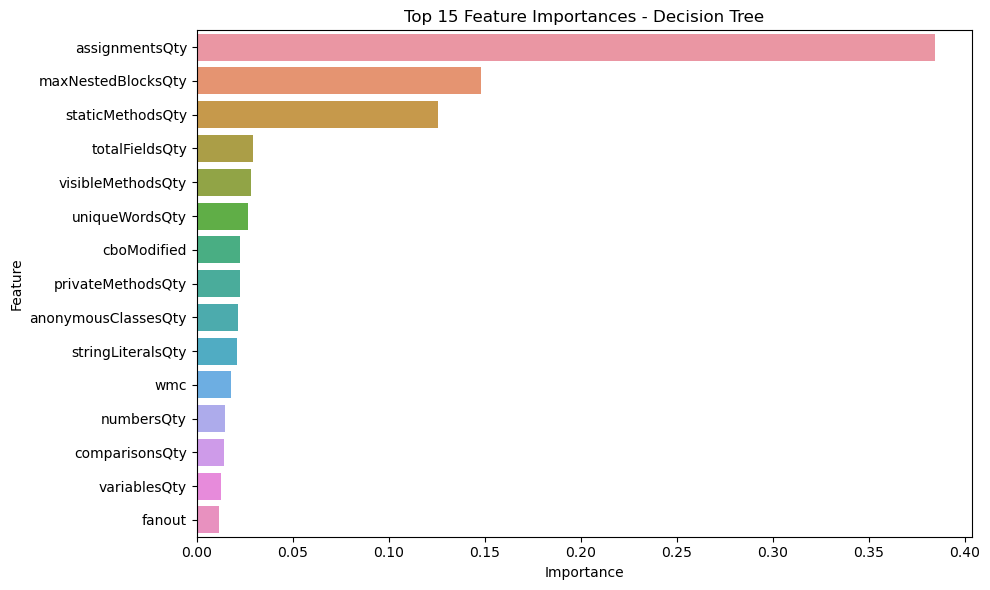

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Now this will work
feature_importances = dt_model.feature_importances_

features = X_train.columns
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(15))
plt.title('Top 15 Feature Importances - Decision Tree')
plt.tight_layout()
plt.show()

In [13]:
!pip install shap

100%|===================| 406655/407540 [01:25<00:00]        

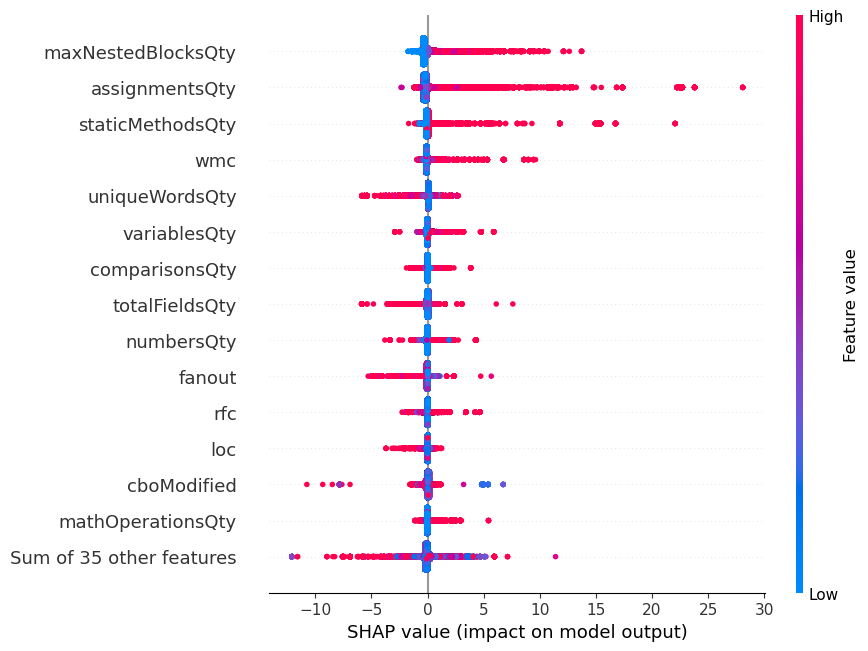

In [14]:
import shap

# Init SHAP Explainer (TreeExplainer for Decision Trees)
explainer = shap.Explainer(dt_model, X_train)

# Compute SHAP values
shap_values = explainer(X_train)

# Beeswarm Plot – Global feature impact
shap.plots.beeswarm(shap_values, max_display=15)

In [15]:
# Find the index with the highest predicted loopQty
max_pred_idx = np.argmax(y_pred)
print("Max prediction:", y_pred[max_pred_idx])

# Find the index with the lowest predicted loopQty
min_pred_idx = np.argmin(y_pred)
print("Min prediction:", y_pred[min_pred_idx])

Max prediction: 47.924595
Min prediction: -3.6174223


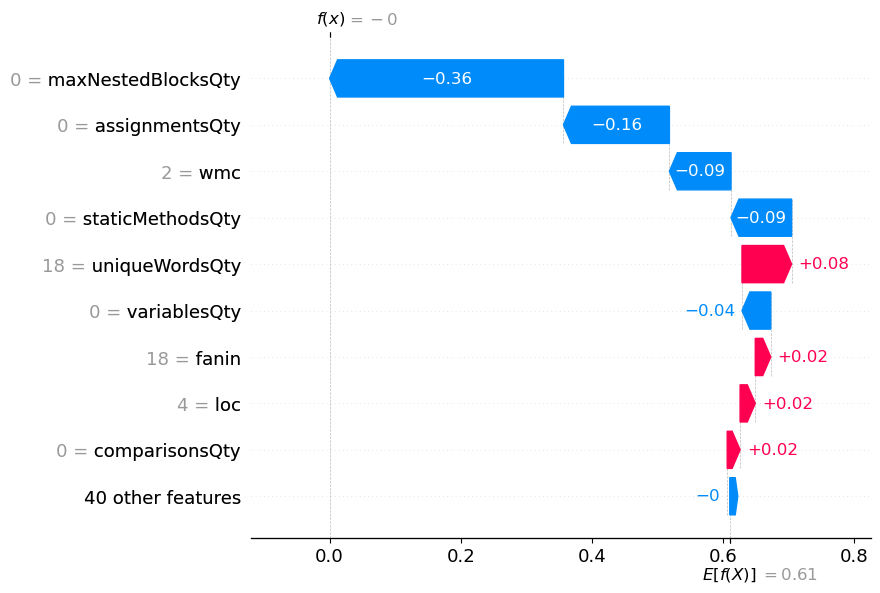

In [16]:
shap.plots.waterfall(shap_values[max_pred_idx])

In [17]:
#Find index of highest prediction
import numpy as np

max_idx = np.argmax(y_pred)  # Finds the index with highest predicted loopQty
print("Index of highest predicted loopQty:", max_idx)
print("Predicted loopQty:", y_pred[max_idx])

Index of highest predicted loopQty: 3127
Predicted loopQty: 47.924595


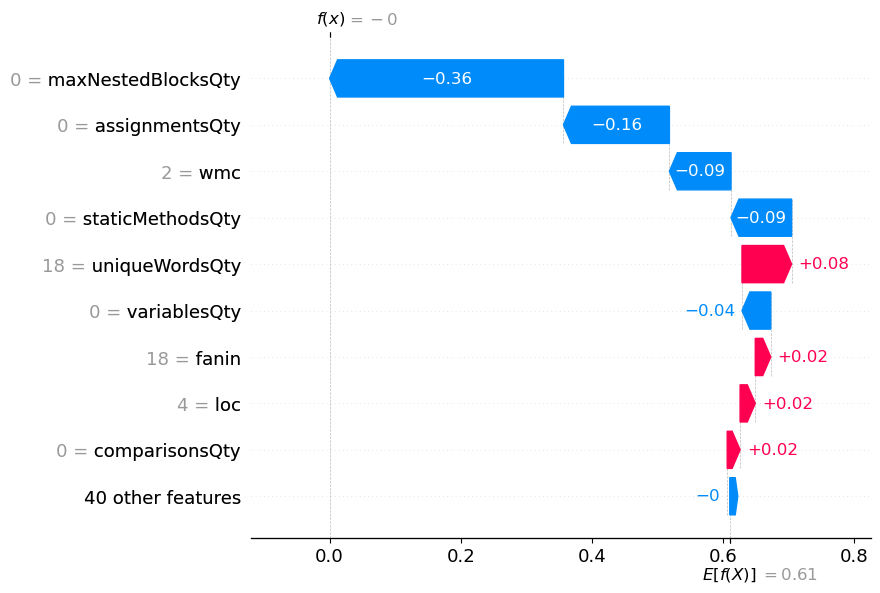

In [18]:
shap.plots.waterfall(shap_values[3127])

In [19]:
import shap

# 1. Explain with TreeExplainer
explainer = shap.Explainer(dt_model, X_train)

# 2. Recalculate SHAP values for the *test set*
shap_values = explainer(X_test)

 96%|=================== | 97438/101886 [00:22<00:01]       

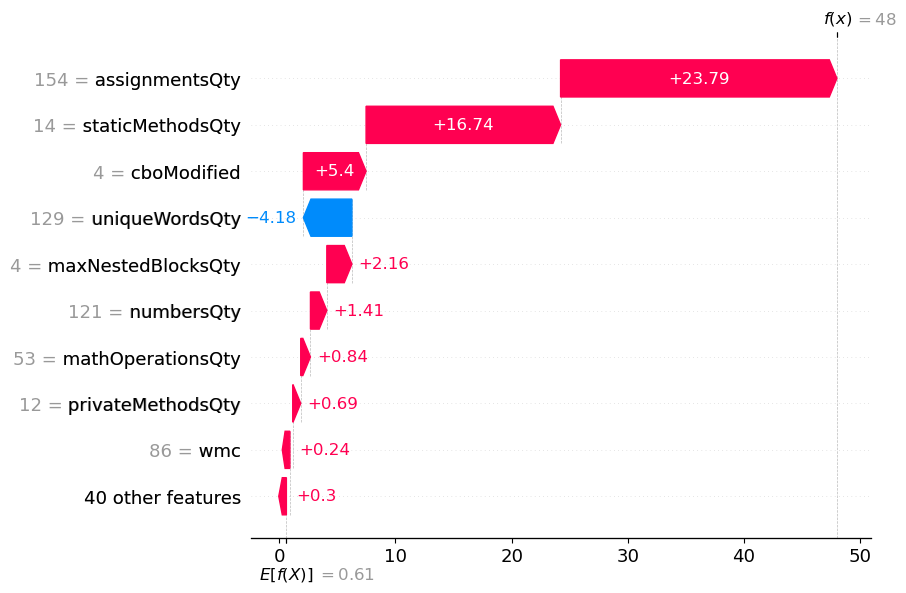

In [20]:
shap.plots.waterfall(shap_values[3127])

In [21]:
# Find index of lowest prediction
min_idx = np.argmin(y_pred)

# Show the actual predicted value
print(f"Index of lowest predicted loopQty: {min_idx}")
print(f"Predicted loopQty: {y_pred[min_idx]}")

Index of lowest predicted loopQty: 22994
Predicted loopQty: -3.617422342300415


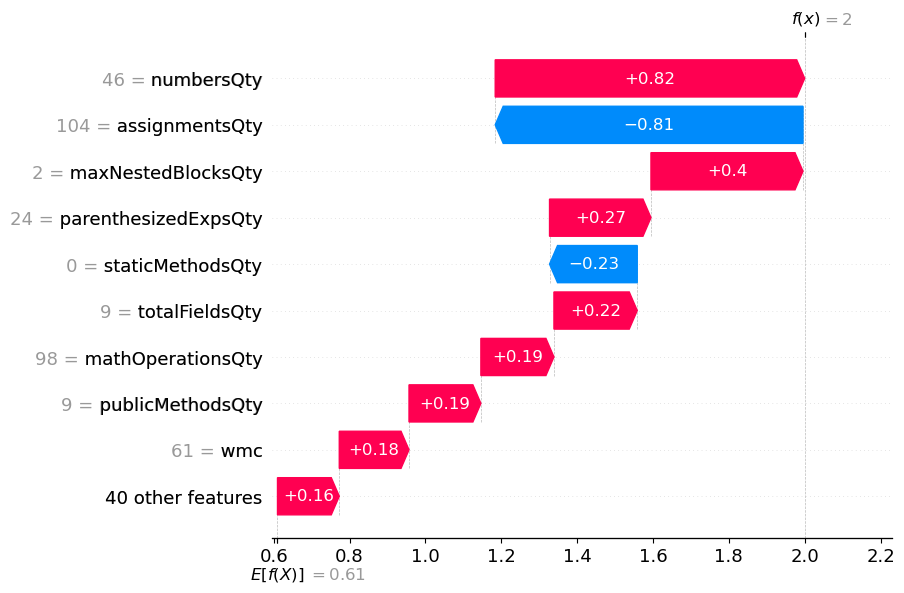

In [22]:
shap.plots.waterfall(shap_values[min_idx])

In [23]:
from sklearn.tree import DecisionTreeRegressor

# 1. Retrain on full data
dt_final_model = DecisionTreeRegressor(random_state=42)
dt_final_model.fit(X, y)

# 2. Save for deployment
import joblib
joblib.dump(dt_final_model, "dt_loopQty_model.pkl")

print("Final model retrained and saved as 'dt_loopQty_model.pkl'")

Final model retrained and saved as 'dt_loopQty_model.pkl'


In [24]:
# Predict loopQty using full model
loopQty_pred = dt_final_model.predict(X)

# Add it as a new feature
X_with_loop = X.copy()
X_with_loop['loopQty_pred'] = loopQty_pred

In [25]:
print(df.columns.tolist())

['refactoring', 'file', 'class', 'type', 'cbo', 'cboModified', 'fanin', 'fanout', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'lcc', 'totalMethodsQty', 'staticMethodsQty', 'publicMethodsQty', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'visibleMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'totalFieldsQty', 'staticFieldsQty', 'publicFieldsQty', 'privateFieldsQty', 'protectedFieldsQty', 'defaultFieldsQty', 'finalFieldsQty', 'synchronizedFieldsQty', 'nosi', 'loc', 'returnQty', 'loopQty', 'comparisonsQty', 'tryCatchQty', 'parenthesizedExpsQty', 'stringLiteralsQty', 'numbersQty', 'assignmentsQty', 'mathOperationsQty', 'variablesQty', 'maxNestedBlocksQty', 'anonymousClassesQty', 'innerClassesQty', 'lambdasQty', 'uniqueWordsQty', 'modifiers', 'logStatementsQty']


In [26]:
df['WCET'] = 3.5 * df['loopQty'] + 0.8 * df['assignmentsQty'] + np.random.normal(0, 2, size=len(df)) #Realistic enough to continue forward

In [27]:
# Drop non-numeric or irrelevant columns
cols_to_drop = ['file', 'class', 'type', 'WCET']  # WCET is the target, not a feature
X2 = df.drop(columns=cols_to_drop)
y2 = df['WCET']

In [28]:
from sklearn.model_selection import train_test_split

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)

In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

dt_wcet = DecisionTreeRegressor(random_state=42)
dt_wcet.fit(X2_train, y2_train)

y2_pred = dt_wcet.predict(X2_test)

# Evaluation
mse = mean_squared_error(y2_test, y2_pred)
r2 = r2_score(y2_test, y2_pred)

print(f"Stage 2 - WCET Prediction")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Stage 2 - WCET Prediction
Mean Squared Error: 4.3397
R² Score: 0.9824


In [30]:
# Save WCET model separately
import joblib
joblib.dump(dt_wcet, "dt_wcet_model.pkl")

print("WCET model saved as 'dt_wcet_model.pkl'")

WCET model saved as 'dt_wcet_model.pkl'


In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

dt_wcet = DecisionTreeRegressor(random_state=42)
dt_wcet.fit(X2_train, y2_train)

y2_pred = dt_wcet.predict(X2_test)

mse = mean_squared_error(y2_test, y2_pred)
r2 = r2_score(y2_test, y2_pred)

print("Stage 2 - WCET Prediction")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Stage 2 - WCET Prediction
Mean Squared Error: 4.3397
R² Score: 0.9824
